In [147]:
from __future__ import annotations

import time
from dataclasses import asdict, dataclass
from pathlib import Path
from typing import Literal

import jax
import jax.numpy as jnp
import liesel.goose as gs
import numpy as np
import optax
import pandas as pd
import torch

import ppptm as gptm

torch.set_default_dtype(torch.float64)
jax.config.update("jax_enable_x64", True)

In [148]:
# ----------------------------------------------------------------------------------
# General settings
# ----------------------------------------------------------------------------------


@dataclass
class Config:
    # job settings
    test: bool = False

    # general model settings
    nlocs: int = 500
    ntrain: int = 20
    ntest: int = 18
    nvalidation: int = 4
    split_seed: int = 1
    m: int = 256  # number of inducing locations
    locs_3d: bool = True

    # marginal model settings
    G_dist: Literal["gaussian1", "gaussian2", "skewt", "gamma", "weibull"] = "gaussian1"
    G_ard: bool = True

    H: bool = True
    H_a: float = -4.0
    H_b: float = 4.0
    H_nparam: int = 40
    H_ard: bool = False
    H_locwise_amplitude: bool = False

    HG_niter: int = 2000
    HG_init_lr: float = 0.01
    HG_patience: int = 10
    HG_tol: float = 0.3
    HG_opt: Literal["adamw", "rmsprop"] = "adamw"

    # transport map settings
    T_niter: int = 1000
    T_init_lr: float = 0.01
    T_patience: int = 10
    T_tol: float = 0.3
    T_batch_size: int | None = 0
    T_opt: Literal["adam", "rmsprop", "lbfgs"] = "rmsprop"

    THG_preprocess: Literal["train", "all-obs", "none", "all-locs"] = "none"

    def __post_init__(self):
        self.ntest = self.ntest - self.nvalidation
        self.T_batch_size = self.T_batch_size if self.T_batch_size > 0 else None

    def save(self, data: dict, path: str | Path) -> pd.DataFrame:
        data_and_config = data | asdict(self)

        df = pd.DataFrame(data_and_config, index=pd.Index([0]))
        df.to_csv(path, index=False)
        return df

In [149]:
config = Config()

In [150]:
# I override config.m here with config.nlocs, because config.nlocs already defines
# all locations that we want to use
config.m = config.nlocs

In [151]:
# ----------------------------------------------------------------------------------
# Data import
# ----------------------------------------------------------------------------------

data = gptm.load_americas()

locs = gptm.LocationVars.new_from(
    data.locs, n_subset=config.m, from_2d_to_3d=config.locs_3d
)
locs_2d = data.locs[locs.locs.ordering, ...][: config.nlocs, ...]
y = data.obs[:, locs.locs.ordering]

In [152]:
# ----------------------------------------------------------------------------------
# Data pre-processing
# ----------------------------------------------------------------------------------
rng = np.random.default_rng(config.split_seed)
rng.shuffle(y, axis=0)


if config.nlocs == -1:
    config.nlocs = 2738

y_model = y[..., : config.nlocs]
locs_model = locs.locs.ordered[: config.nlocs, ...]

locs.ordered.value = locs.locs.ordered[: config.nlocs, ...]

train, validate, test = (
    y_model[: config.ntrain, :],
    y_model[-(config.ntest + config.nvalidation) : -config.ntest, :],
    y_model[-config.ntest :, :],
)

if config.nvalidation == 0:
    validate = train

if config.G_dist in ["gamma", "weibull"]:
    config.THG_preprocess = "none"

match config.THG_preprocess:
    case "train":
        train_means = train.mean(axis=0, keepdims=True)
        train_sds = train.std(axis=0, keepdims=True)
    case "all-obs":
        train_means = y_model.mean(axis=0, keepdims=True)
        train_sds = y_model.std(axis=0, keepdims=True)
    case "all-locs":
        train_means = y_model.mean(keepdims=True)
        train_sds = y_model.std(keepdims=True)
    case "none":
        train_means = 0.0
        train_sds = 1.0

train = (train - train_means) / train_sds
validate = (validate - train_means) / train_sds
test = (test - train_means) / train_sds

logdet_addition = -jnp.log(train_sds)

In [153]:
# ----------------------------------------------------------------------------------
# Marginal model
# ----------------------------------------------------------------------------------

# set up G

match config.G_dist:
    case "gaussian1":
        G = gptm.G(train, locs, ard=config.G_ard)
        g = G.new_gaussian()
        locscale = True
    case "gaussian2":
        G = gptm.G(train, locs, ard=config.G_ard)
        g = G.new_gaussian(locwise=[])
        locscale = True
    case "skewt":
        G = gptm.G(train, locs, ard=config.G_ard)
        g = G.new_skewt()
        locscale = False
    case "gamma":
        train = jnp.exp(train)
        validate = jnp.exp(validate)
        test = jnp.exp(test)
        G = gptm.G(train, locs, ard=config.G_ard)
        g = G.new_gamma()
        locscale = False
        logdet_addition = logdet_addition + jnp.log(test)
    case "weibull":
        train = jnp.exp(train)
        validate = jnp.exp(validate)
        test = jnp.exp(test)
        G = gptm.G(train, locs, ard=config.G_ard)
        g = G.new_weibull()
        locscale = False
        logdet_addition = logdet_addition + jnp.log(test)


# set up H
h = gptm.H(
    locs,
    ard=config.H_ard,
    locwise_amplitude=config.H_locwise_amplitude,
).new_coef()

# set up model
if config.H:
    marginal_model = gptm.Model.new_HG(
        train,
        locs,
        g_dist=g,
        coef=h,
        locscale=locscale,
        a=config.H_a,
        b=config.H_b,
        nparam=config.H_nparam,
    )
else:
    marginal_model = gptm.Model.new_G(train, locs, g, locscale=locscale)


# fit model
scheduler = optax.cosine_decay_schedule(
    init_value=config.HG_init_lr, decay_steps=config.HG_niter
)
match config.HG_opt:
    case "adamw":
        hg_opt = optax.adamw(learning_rate=scheduler, weight_decay=1e-4)
    case "rmsprop":
        hg_opt = optax.rmsprop(learning_rate=scheduler)

gradient_clipping = optax.clip_by_global_norm(1.0)
marginal_opt = optax.chain(gradient_clipping, hg_opt)

start = time.time()
result = marginal_model.fit(
    stopper=gs.Stopper(
        max_iter=config.HG_niter, patience=config.HG_patience, atol=config.HG_tol
    ),
    response_validation=validate if config.nvalidation > 0 else None,
    optimizer=marginal_opt,
    progress_bar=True,
)
end = time.time()
time_hg = end - start

Training loss: 33825.133, Validation loss: 34568.788:   4%|▍         | 87/2000 [00:06<01:21, 23.61it/s]  

In [154]:
from liesel_ptm.util.plots import plot_loss, plot_param_history

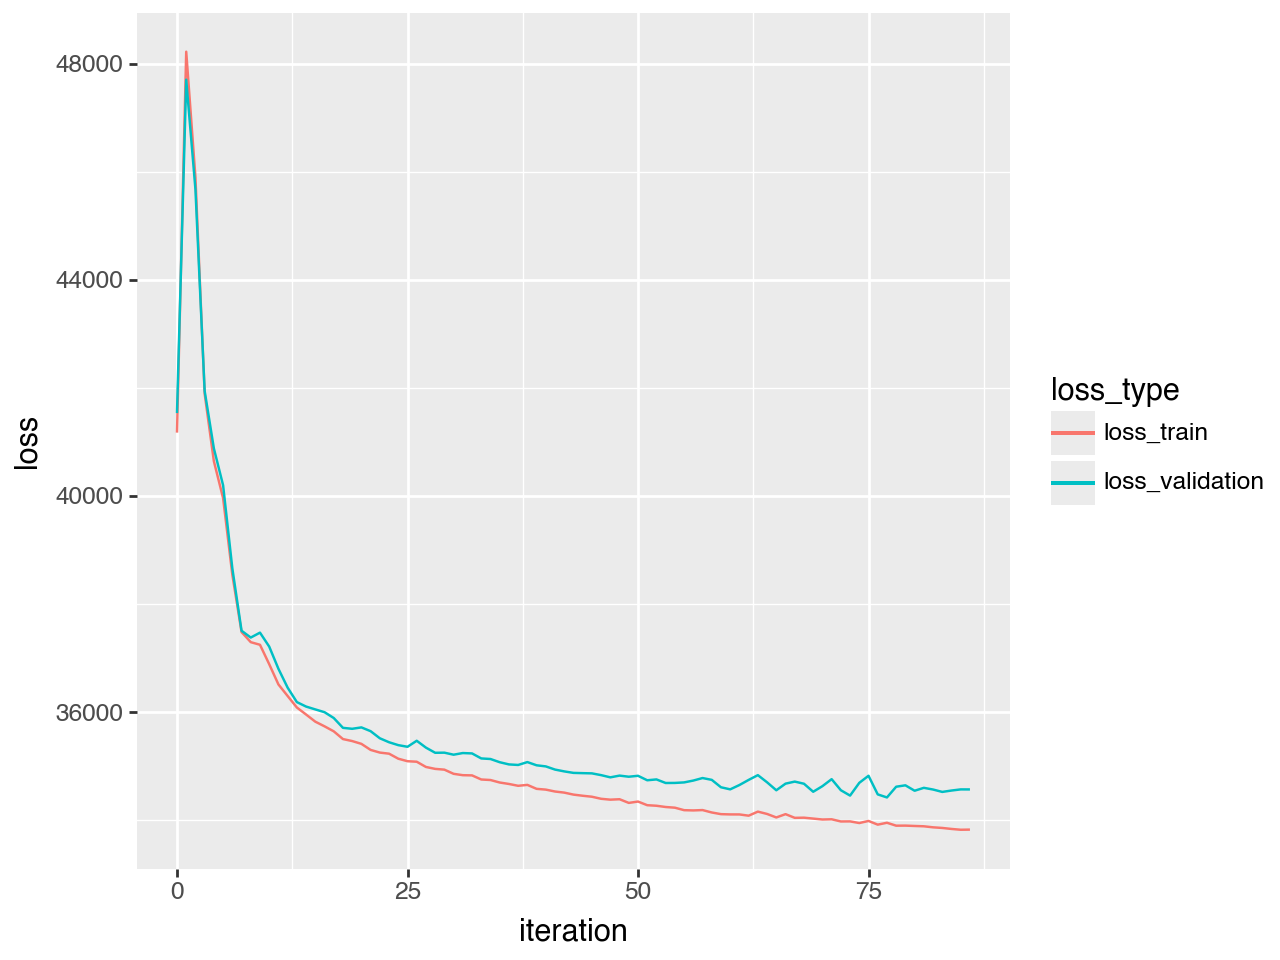

In [155]:
plot_loss(result)

### Plot a transformed sample of the training observations

This is mainly a plausibility check, confirming that we used a subset of the available locations as intended.

In [156]:
train_hg = marginal_model.hg(train)
train_hg_df = gptm.long_df(locs_2d, train_hg)
train_hg_df

,loc,lon,lat,obs,value
0,0,272.50,4.240838,0,-1.009412
1,1,250.00,39.109948,0,1.770021
2,2,250.00,-29.685864,0,0.398406
3,3,295.00,-28.743455,0,-0.929605
4,4,295.00,34.397906,0,1.108598
...,...,...,...,...,...
9995,495,282.50,34.397906,19,-1.004167
9996,496,258.75,-21.204188,19,0.355827
9997,497,275.00,-19.319372,19,0.946017
9998,498,278.75,-7.068063,19,0.896813


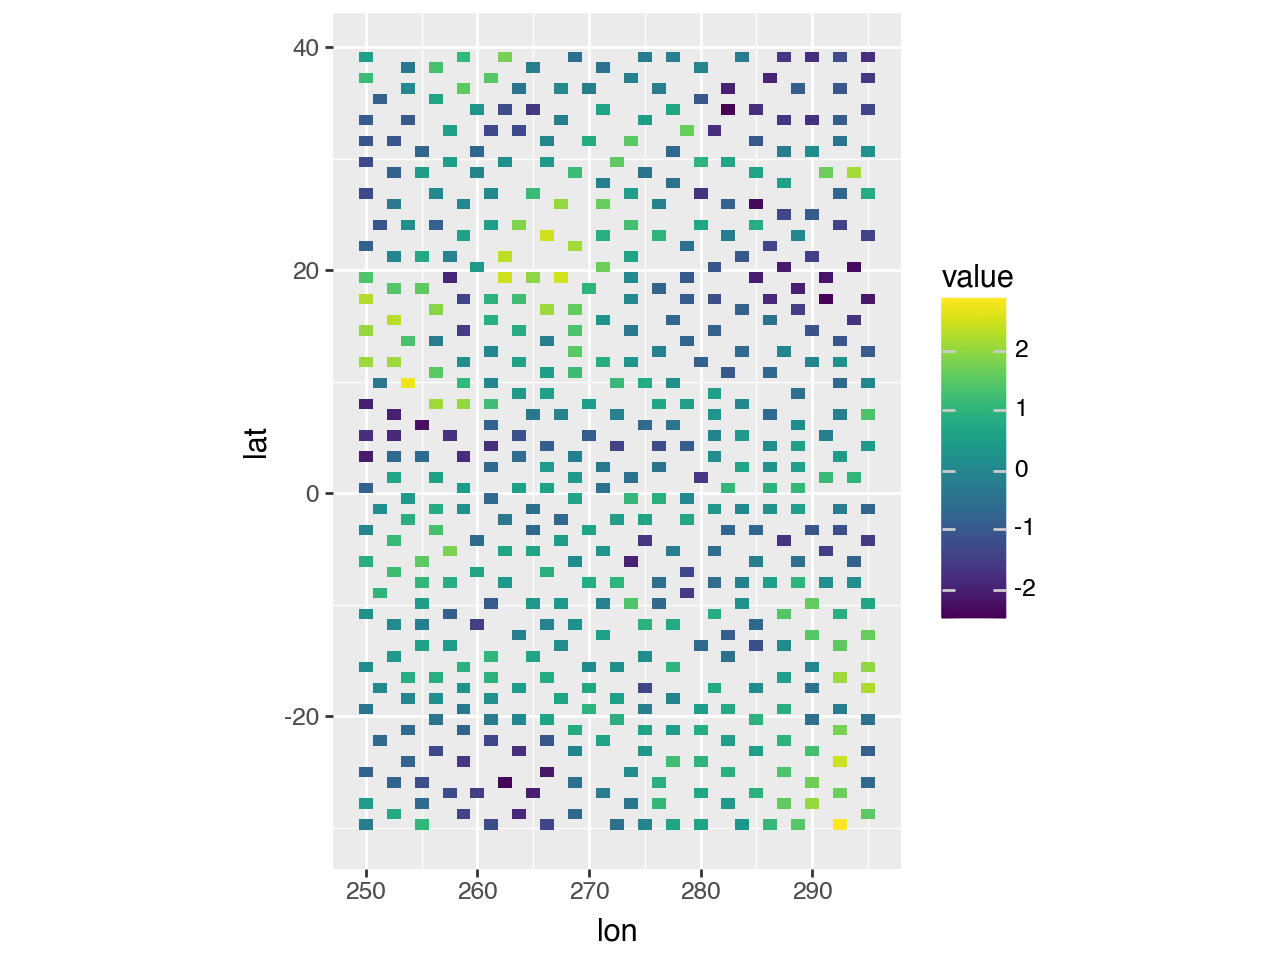

In [157]:
gptm.plot_df(train_hg_df.query("obs == 5"))

### Update model with new locations

Now we exchange the location data in the model.

In [158]:
all_locs_3d = locs.locs.ordered
all_locs_2d = data.locs[locs.locs.ordering, ...]
all_response = data.obs[:, locs.locs.ordering]

all_train, all_validate, all_test = (
    all_response[: config.ntrain, :],
    all_response[-(config.ntest + config.nvalidation) : -config.ntest, :],
    all_response[-config.ntest :, :],
)

if config.nvalidation == 0:
    all_validate = all_train

# updates model state
marginal_model.graph.state = marginal_model.graph.update_state(
    {
        marginal_model.locs.ordered.name: all_locs_3d,
        # most important is just just that the location dimension of the values supplied
        # here fits to the supplied locations
        marginal_model.response.name: all_train,
    }
)

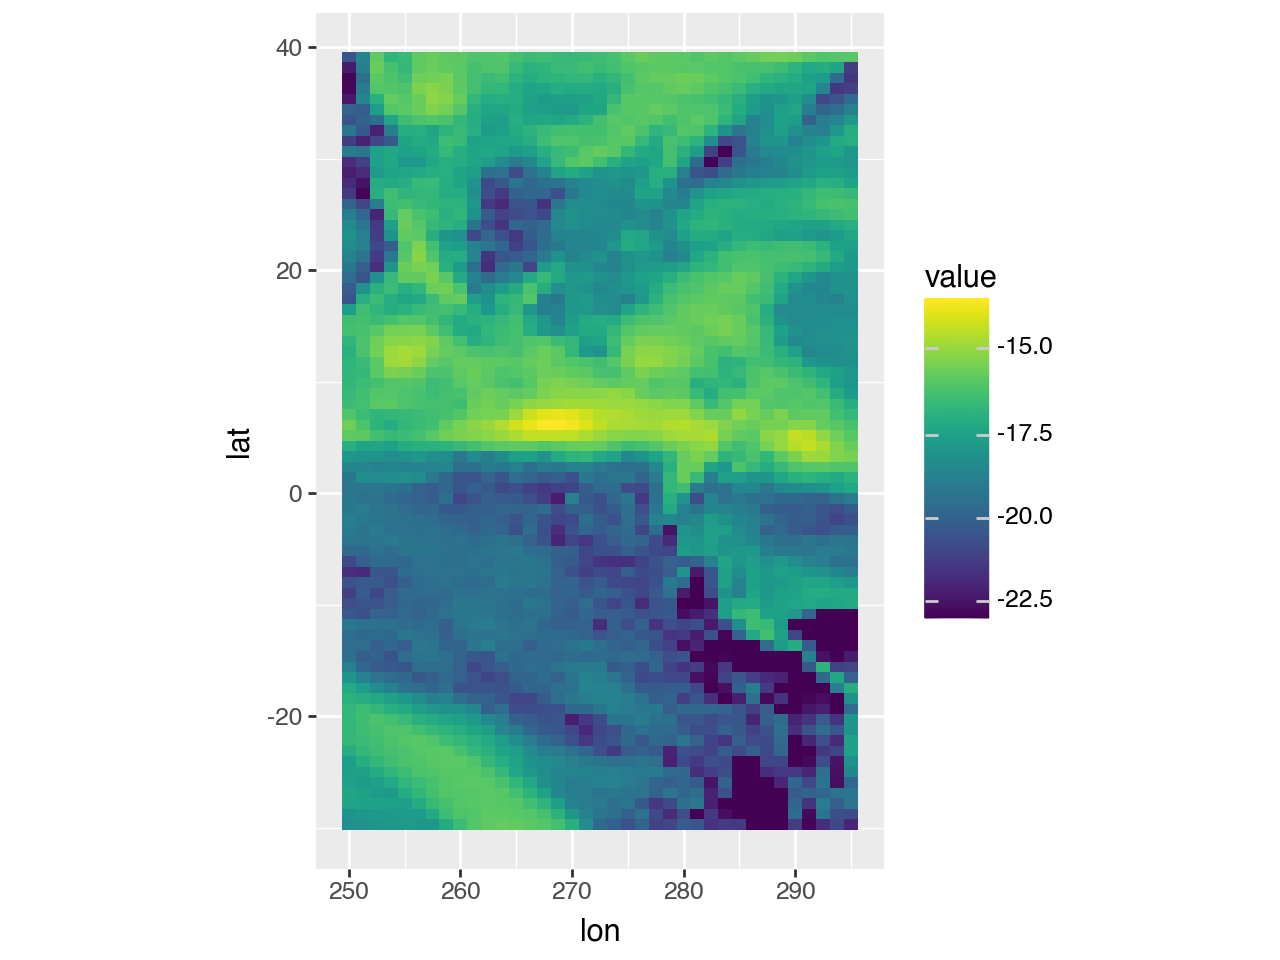

In [159]:
# plot of training data at all locations
all_hg_df = gptm.long_df(all_locs_2d, all_response)
gptm.plot_df(all_hg_df.query("obs == 5"))

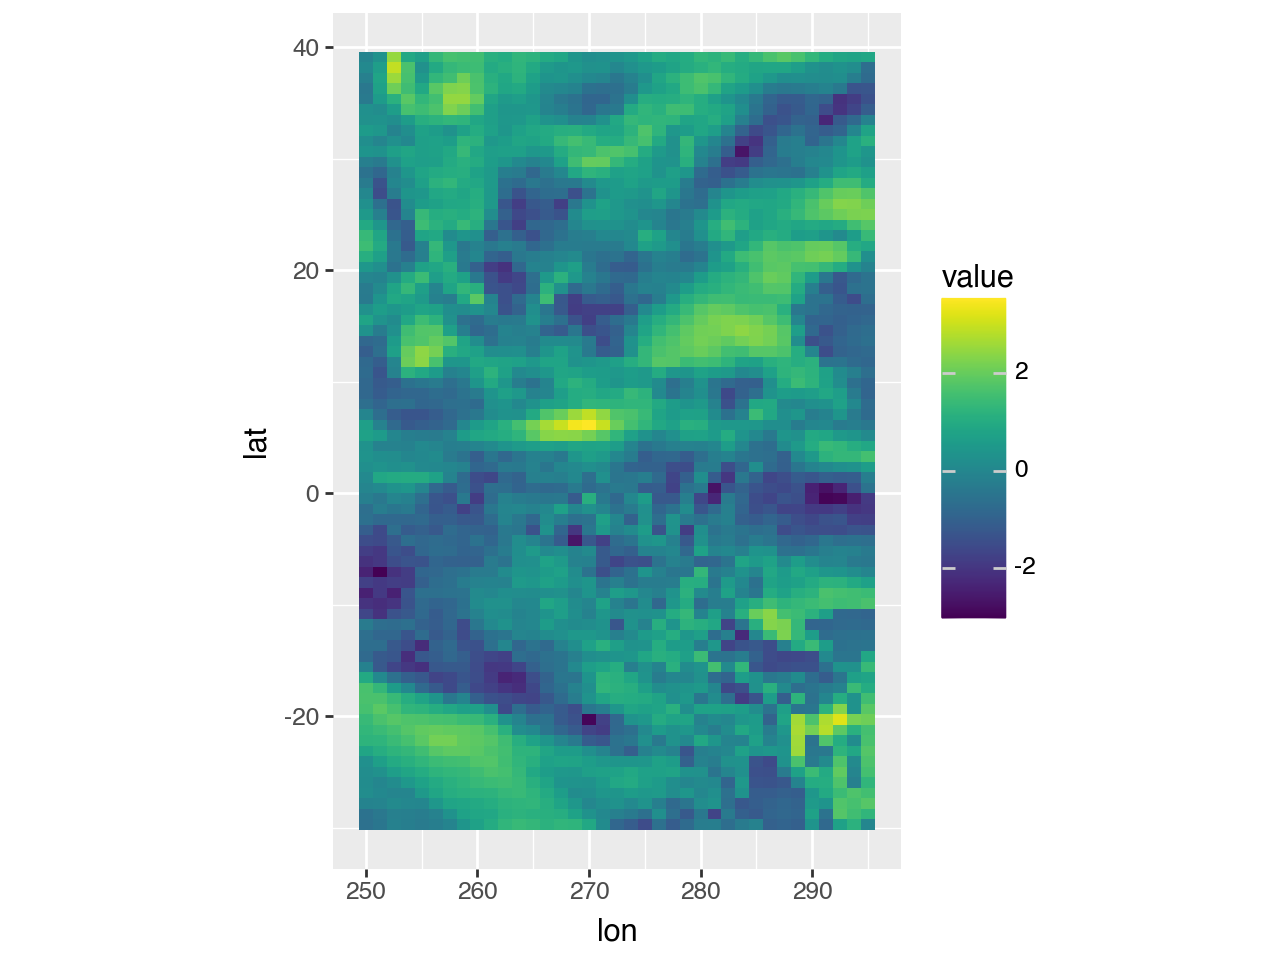

In [160]:
# plot of transformed training data at all locations
all_hg = marginal_model.hg(all_response)
all_hg_df = gptm.long_df(all_locs_2d, all_hg)
gptm.plot_df(all_hg_df.query("obs == 5"))

## Prediction of G parameters at locations not in the training data

In [161]:
# if you want to quickly print the right names of the parameters in G
marginal_model.response.dist_node.kwinputs

mappingproxy({'coef': VarValue(name="coef_var_value"),
              'loc': VarValue(name="loc_var_value"),
              'scale': VarValue(name="scale_var_value")})

In [162]:
# this is the variable name for the sample locations
# we need this as the dictionary key in 'newdata' in the following code block
marginal_model.locs.sample_locs.name

'sample_locs'

In [163]:
# result.position is a dictionary of final parameter values (at inducing locations)
# I prepend two dimensions here to bring the arrays into a format accepted
# by liesel.model.Model.predict
position = jax.tree.map(lambda x: jnp.expand_dims(x, (0, 1)), result.position)

# compute the prediction
prediction = marginal_model.graph.predict(
    samples=position,
    newdata={"sample_locs": locs.locs.ordered},
    predict=["loc", "scale"],  # names of the variables that you want to predict
)

In [164]:
# the predicted arrays also have the two prepended axes
# I don't want that, so I remove them.
print(prediction["loc"].shape)
prediction = jax.tree.map(jnp.squeeze, prediction)
print(prediction["loc"].shape)

(1, 1, 2738)
(2738,)


In [165]:
df = gptm.long_df_multiple(
    data.locs[locs.locs.ordering, ...],
    mu=prediction["loc"],
    sigma=prediction["scale"],
)

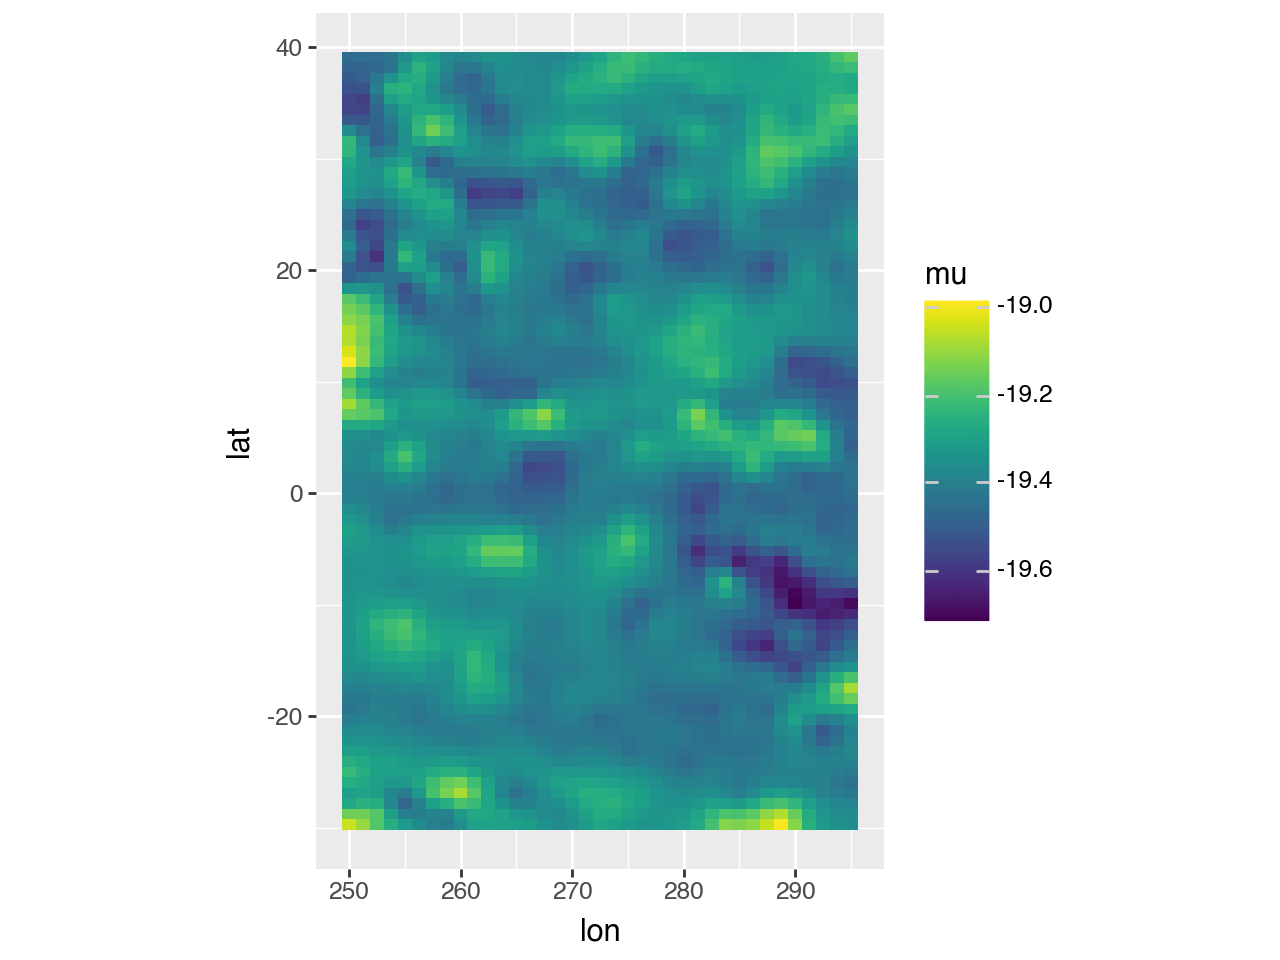

In [166]:
gptm.plot_df(df, "mu")

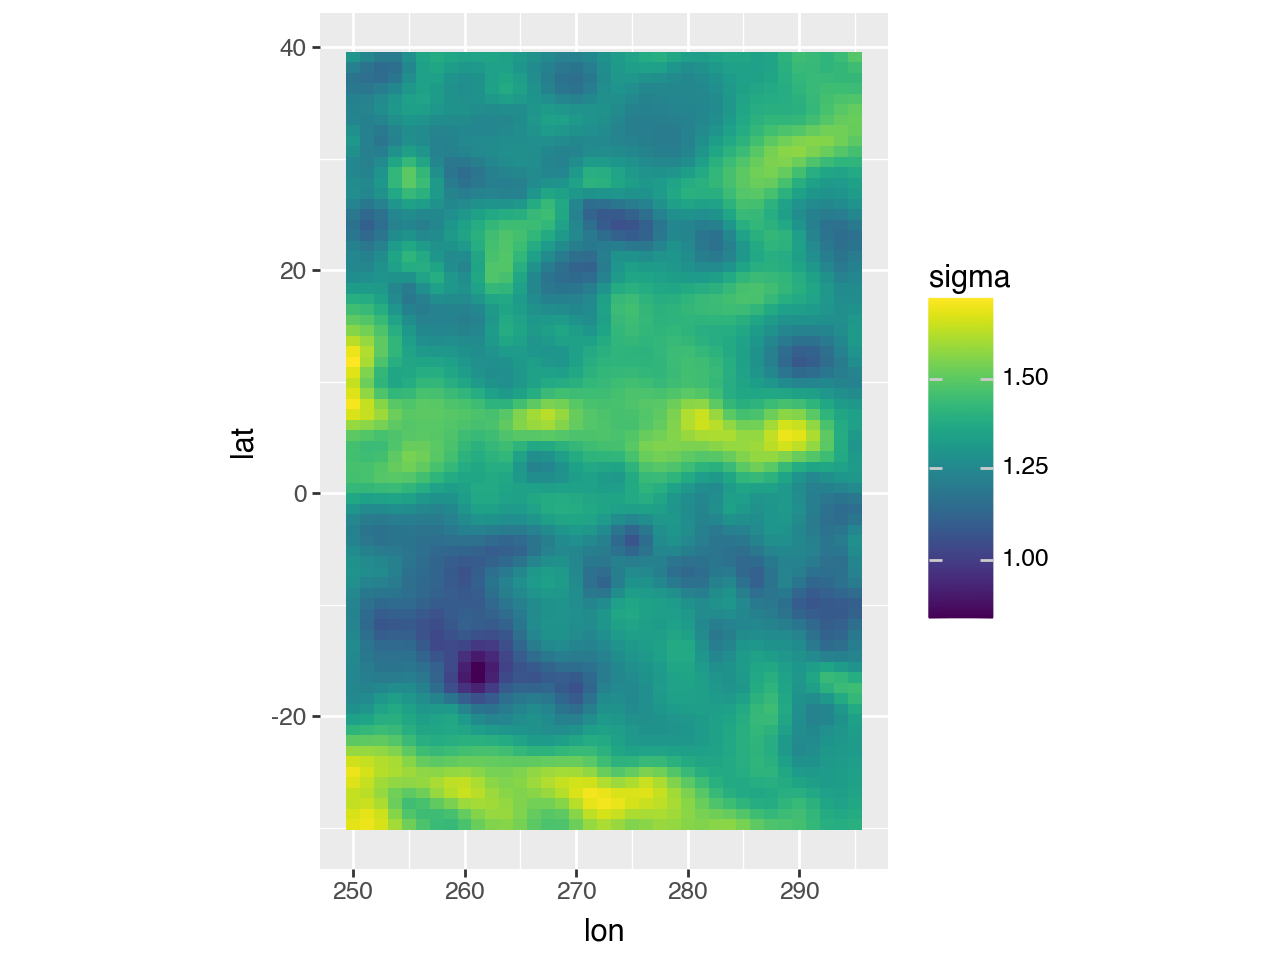

In [167]:
gptm.plot_df(df, "sigma")

## Illustration: Full marginal mean

To include the parts of the marginal mean and standard deviation captured by H,
I draw samples from the combined model here and take their sample mean and std.

In [ ]:
from jax.random import key

# note that this is the version of the marginal model that we updated above to now use
# all locations
samp = marginal_model.init_dist().sample((500), seed=key(2))

In [ ]:
df = gptm.long_df_multiple(
    data.locs[locs.locs.ordering, ...],
    mu=samp.mean(axis=0),
    sigma=samp.std(axis=0),
)

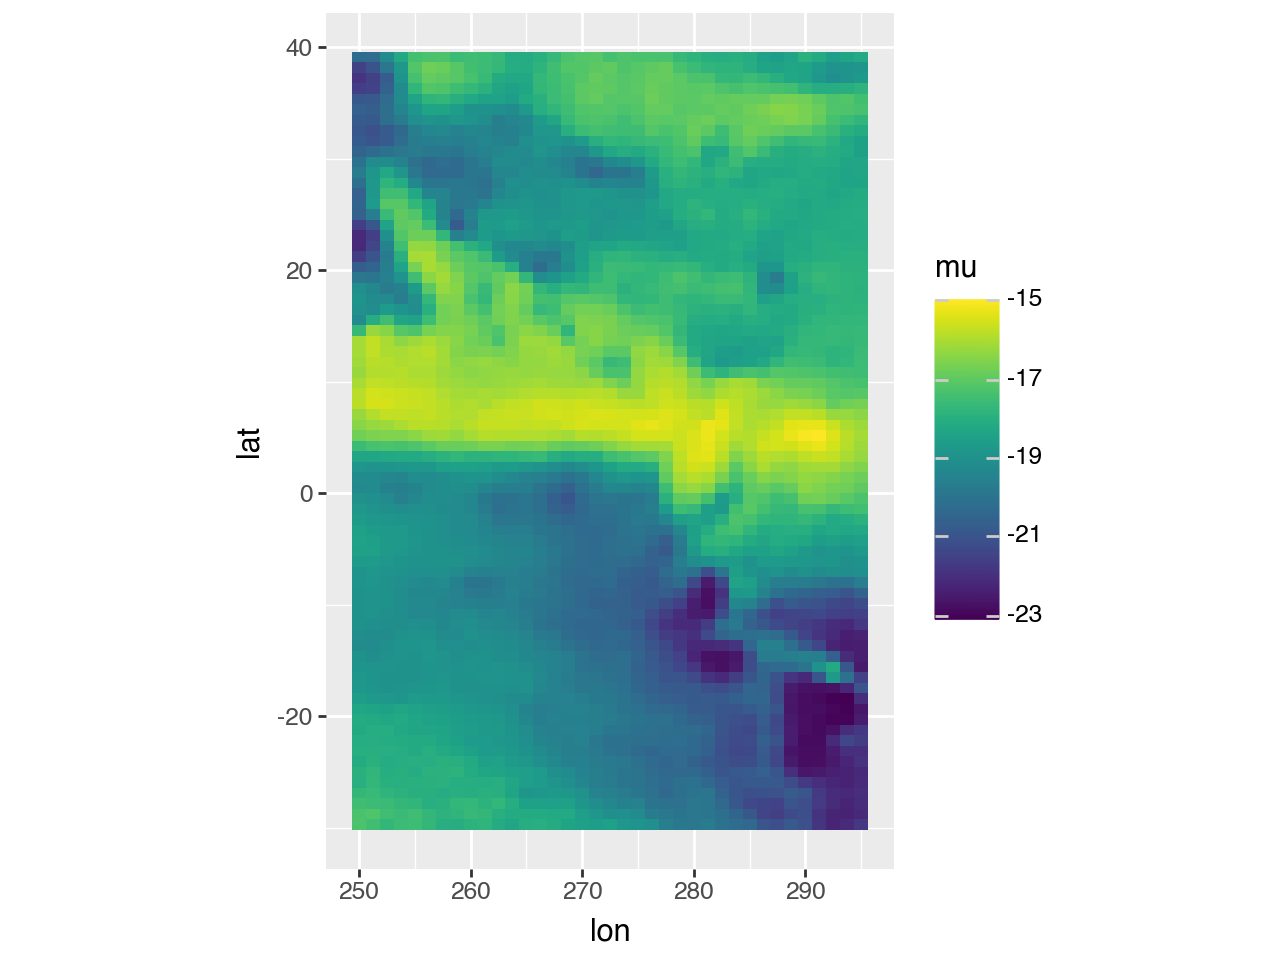

In [171]:
gptm.plot_df(df, "mu")

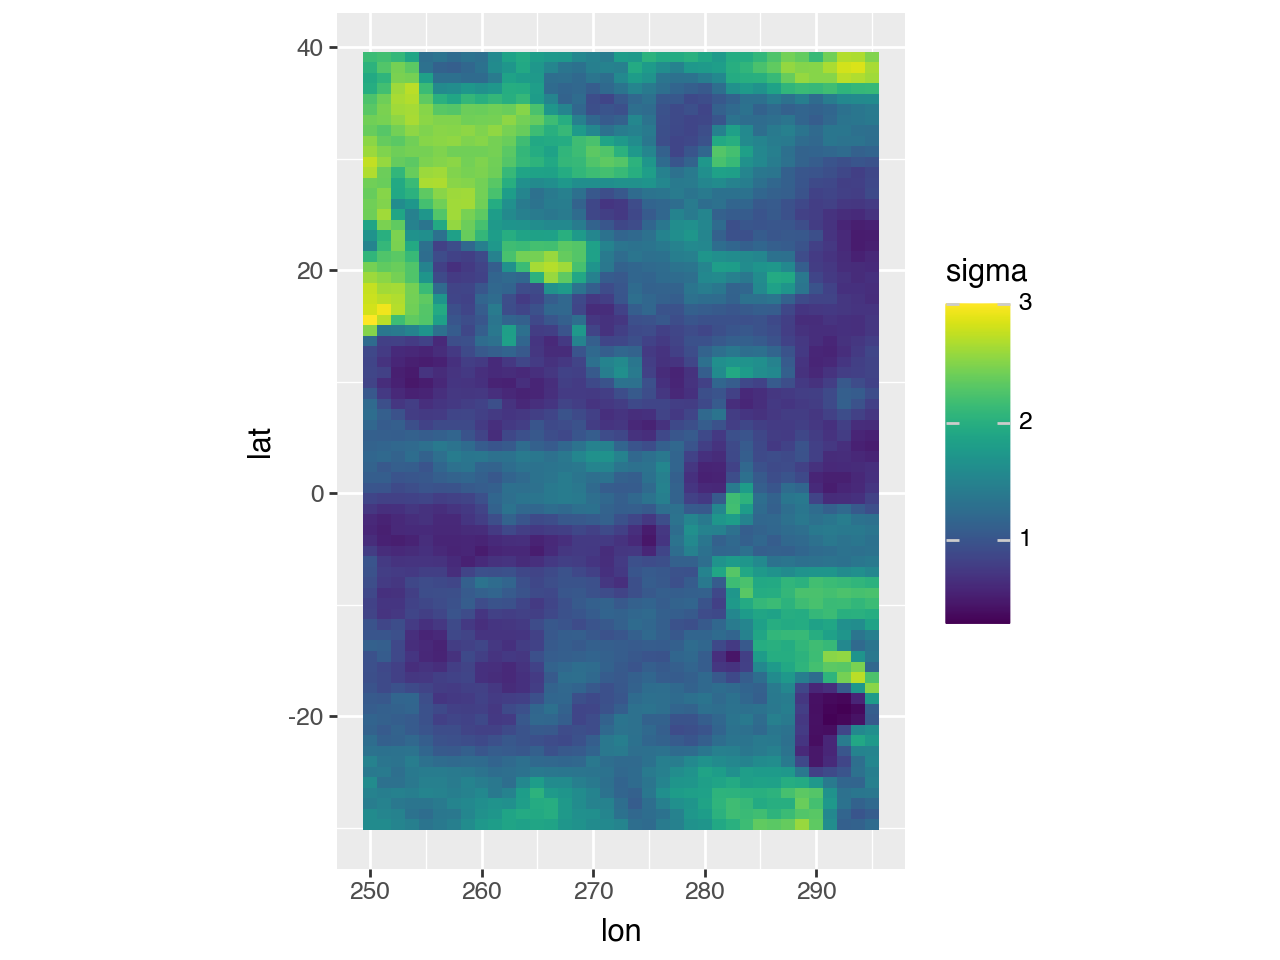

Training loss: 33825.133, Validation loss: 34568.788:   4%|▍         | 87/2000 [00:19<01:21, 23.61it/s]

In [172]:
gptm.plot_df(df, "sigma")